# <h1><b><I> General Setup

## Imports and general setup

In [1]:
import os, sys, time
from tqdm import tqdm

# from gammabayes.BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc, darkmatterdoubleinput, energymassinputspectralfunc
from gammabayes.likelihoods.instrument_response_funcs_tst import log_bkg_CCR_dist, log_edisp, log_psf, single_loglikelihood
from scipy import interpolate, special, integrate
from gammabayes.utils.event_axes import log10eaxistrue, longitudeaxistrue, latitudeaxistrue, log10eaxis, longitudeaxis, latitudeaxis
# from gammabayes.utils.utils import inverse_transform_sampling
from gammabayes.hyper_inference.hyperparameter_likelihood import hyperparameter_likelihood
from gammabayes.priors.prior import discrete_logprior
from gammabayes.likelihoods.discrete_loglikelihood import discrete_loglikelihood
from gammabayes.dark_matter.Z2_ScalarSinglet.SS_DM_Constructor import SS_DM_dist
from gammabayes.utils.utils import convertlonlat_to_offset, bin_centres_to_edges


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from astropy import units as u
from scipy import special,stats
from scipy.integrate import simps
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm

import functools, random
from multiprocessing import Pool, freeze_support
import multiprocessing
import pandas as pd

random.seed(0)


/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from scipy import stats

sigma_to_percentage = lambda sigma: stats.norm.cdf(sigma)-stats.norm.cdf(-sigma)

In [3]:
import pkg_resources

resource_file_path = pkg_resources.resource_filename('gammabayes', 'package_data')

diffuse_astrophysicalbackground = np.load(f"{resource_file_path}/unnormalised_astrophysical_diffuse_background.npy")
point_astrophysicalbackground = np.load(f"{resource_file_path}/unnormalised_astrophysical_point_background.npy")
psfnormalisationvalues = np.load(f"{resource_file_path}/psfnormalisation.npy")
edispnormalisationvalues = np.load(f"{resource_file_path}/edispnormalisation.npy")


In [4]:
log10emeshtrue, lonmeshtrue, latmeshtrue = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')
lonmeshrecon, latmeshrecon = np.meshgrid(longitudeaxis, latitudeaxis, indexing='ij')

logjacobtrue = np.meshgrid(np.log(10**log10eaxistrue), longitudeaxistrue, latitudeaxistrue, indexing='ij')[0]


print(lonmeshtrue.shape, lonmeshrecon.shape)

(601, 35, 30) (18, 15)


## Script Parameter Setup

In [5]:
numberoftruevaluesamples = int(5e3)
Nsamples=numberoftruevaluesamples
sigfraction                 = 0.5
ccr_of_bkg_fraction         = 0.5
diffuse_of_astro_fraction   = 0.3333333
nsig                        = int(round(sigfraction*Nsamples))
nastrodiffuse               = int(round((1-sigfraction)*(1-ccr_of_bkg_fraction)*diffuse_of_astro_fraction*Nsamples))
nastropoint                 =int(round((1-sigfraction)*(1-ccr_of_bkg_fraction)*(1-diffuse_of_astro_fraction)*Nsamples))
nccr                        = int(round((1-sigfraction)*ccr_of_bkg_fraction*Nsamples))
if nccr+nastrodiffuse+nastropoint+nsig!=numberoftruevaluesamples:
    print(1/0)
numcores            = 8
truelogmass         = 0.0

startertimer = time.perf_counter()
print(startertimer)

231078.130389208


# <h1><b>Simulation

## Setup

### Diffuse Astro Background setup

In [6]:
unnormed_log_diffuse_astrobkgpriorvalues = np.log(diffuse_astrophysicalbackground)

log_astro_diffuse_bkgpriorvalues = unnormed_log_diffuse_astrobkgpriorvalues - special.logsumexp(unnormed_log_diffuse_astrobkgpriorvalues+logjacobtrue)




log_bkgastro_diffuse = interpolate.RegularGridInterpolator((log10eaxistrue, longitudeaxistrue, latitudeaxistrue), np.exp(log_astro_diffuse_bkgpriorvalues))
log_diffuse_astro_bkgfunc = lambda logenergy, longitude, latitude: np.log(log_bkgastro_diffuse((logenergy, longitude, latitude)))


diffuse_astro_bkg_prior = discrete_logprior(logfunction=log_diffuse_astro_bkgfunc, name='Diffuse Astrophysical Background Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=logjacobtrue)



In [7]:
unnormed_log_point_astrobkgpriorvalues = np.log(point_astrophysicalbackground)

log_astro_point_bkgpriorvalues = unnormed_log_point_astrobkgpriorvalues - special.logsumexp(unnormed_log_point_astrobkgpriorvalues+logjacobtrue)




log_bkgastro_point = interpolate.RegularGridInterpolator((log10eaxistrue, longitudeaxistrue, latitudeaxistrue), np.exp(log_astro_point_bkgpriorvalues))
log_point_astro_bkgfunc = lambda logenergy, longitude, latitude: np.log(log_bkgastro_point((logenergy, longitude, latitude)))


point_astro_bkg_prior = discrete_logprior(logfunction=log_point_astro_bkgfunc, name='Point Source Astrophysical Background Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=logjacobtrue)



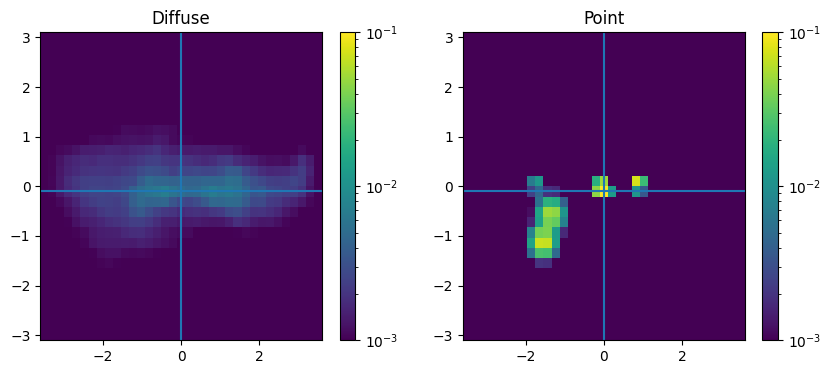

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Diffuse')
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, np.exp(special.logsumexp(log_astro_diffuse_bkgpriorvalues+logjacobtrue, axis=0)).T,
               norm=LogNorm(vmin=1e-3, vmax=1e-1))
lonmesh, latmesh = np.meshgrid(longitudeaxistrue, latitudeaxistrue, indexing='ij')
zeroindex = convertlonlat_to_offset(np.array([lonmesh.flatten(), latmesh.flatten()])).argmin()
zeroindex_coord = np.unravel_index(zeroindex, shape=lonmesh.shape)
plt.axvline(longitudeaxistrue[zeroindex_coord[0]])
plt.axhline(latitudeaxistrue[zeroindex_coord[1]])
plt.colorbar()

plt.subplot(122)
plt.title('Point')
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, np.exp(special.logsumexp(log_astro_point_bkgpriorvalues+logjacobtrue, axis=0)).T,
               norm=LogNorm(vmin=1e-3, vmax=1e-1))
lonmesh, latmesh = np.meshgrid(longitudeaxistrue, latitudeaxistrue, indexing='ij')
zeroindex = convertlonlat_to_offset(np.array([lonmesh.flatten(), latmesh.flatten()])).argmin()
zeroindex_coord = np.unravel_index(zeroindex, shape=lonmesh.shape)
plt.axvline(longitudeaxistrue[zeroindex_coord[0]])
plt.axhline(latitudeaxistrue[zeroindex_coord[1]])
plt.colorbar()

In [9]:
ccr_bkg_prior = discrete_logprior(logfunction=log_bkg_CCR_dist, name='CCR Mis-identification Background Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=logjacobtrue)

### Signal Setup

In [10]:
SS_DM_dist_instance= SS_DM_dist(longitudeaxistrue, latitudeaxistrue)
logDMpriorfunc = SS_DM_dist_instance.func_setup()

In [11]:
DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), axes_names=['energy', 'lon', 'lat'],
                               default_hyperparameter_values=(truelogmass,), hyperparameter_names=['mass'], logjacob=logjacobtrue)
DM_prior

(0.0,)


discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist.func_setup.<locals>.DM_signal_dist at 0x1575a7f60>
input units of None
over axes ['energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

## True Value Simulation

In [12]:
if nsig!=0:
    siglogevals,siglonvals,siglatvals  = DM_prior.sample(nsig)
else:
    siglogevals = np.asarray([])
    siglonvals = np.asarray([])
    siglatvals = np.asarray([])

if nccr!=0:
    ccrlogevals,ccrlonvals,ccrlatvals  = ccr_bkg_prior.sample(nccr)
else:
    ccrlogevals = np.asarray([])
    ccrlonvals = np.asarray([])
    ccrlatvals = np.asarray([])

if nastrodiffuse!=0:
    diffuse_astrologevals,diffuse_astrolonvals,diffuse_astrolatvals  = diffuse_astro_bkg_prior.sample(nastrodiffuse)
else:
    diffuse_astrologevals = np.asarray([])
    diffuse_astrolonvals = np.asarray([])
    diffuse_astrolatvals = np.asarray([])

if nastropoint!=0:
    point_astrologevals,point_astrolonvals,point_astrolatvals  = point_astro_bkg_prior.sample(nastropoint)
else:
    point_astrologevals = np.asarray([])
    point_astrolonvals = np.asarray([])
    point_astrolatvals = np.asarray([])



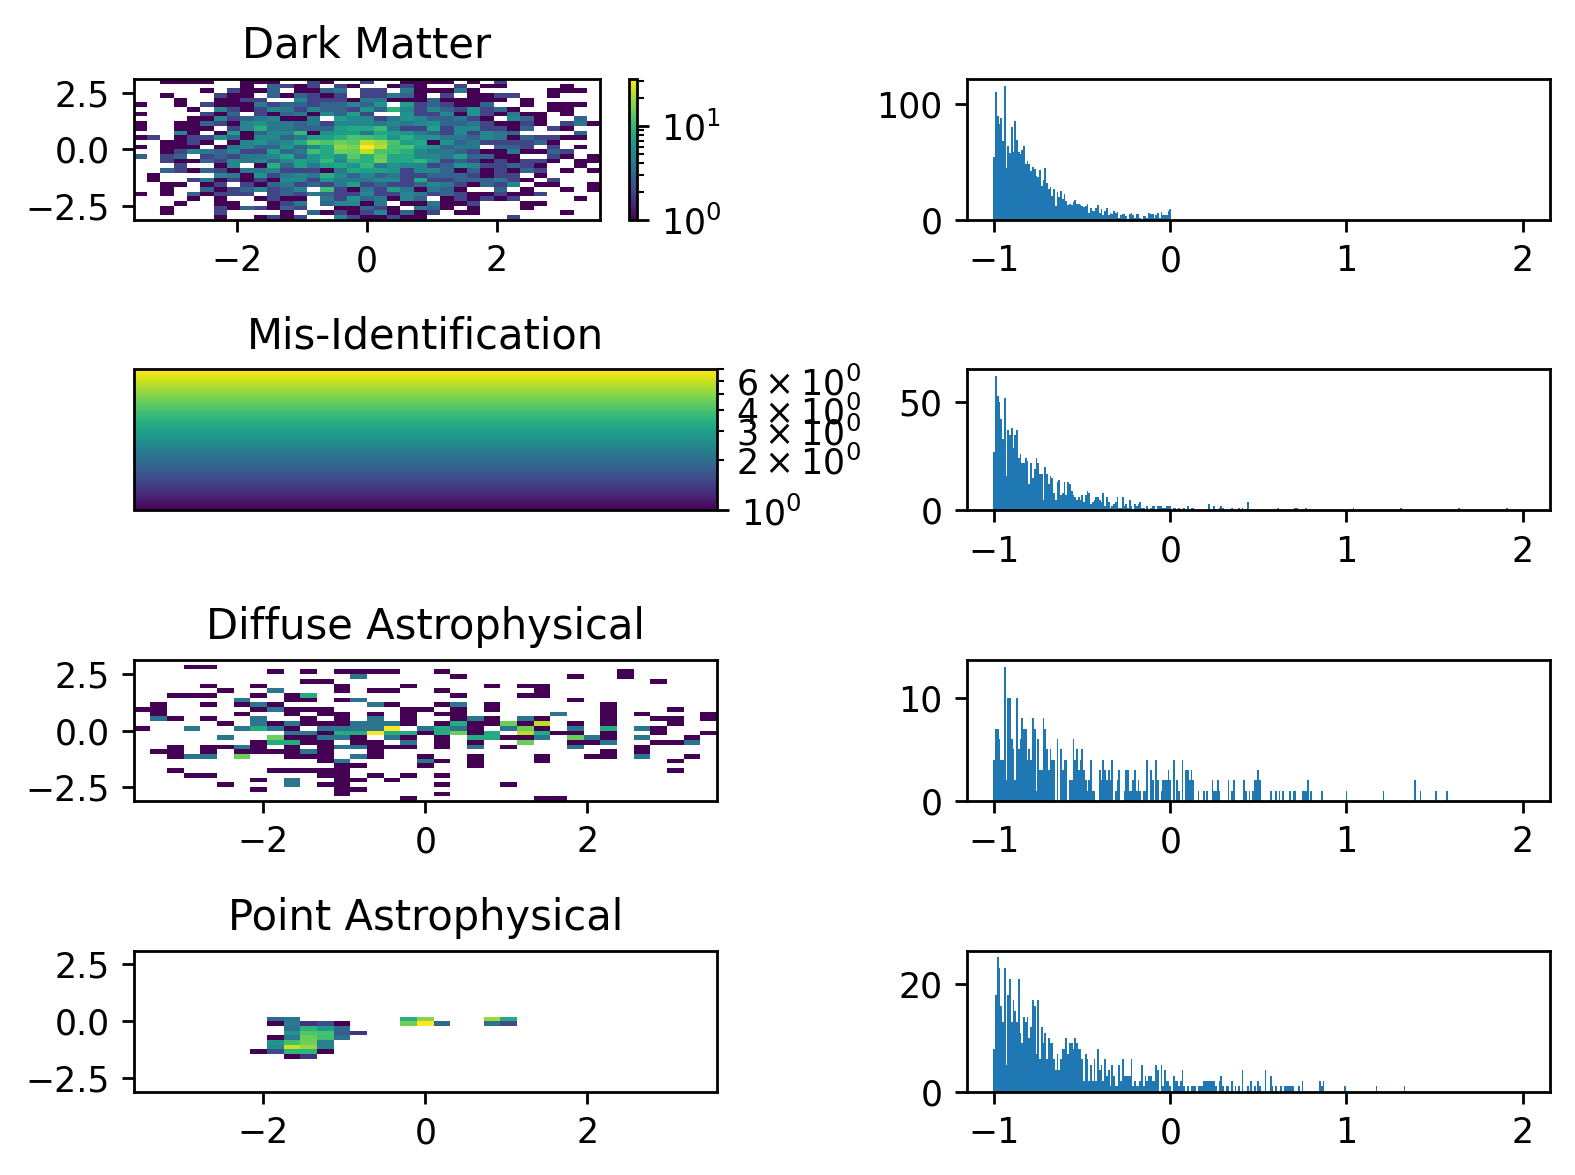

In [13]:
fig, ax = plt.subplots(4,2, dpi=250)

ax[0,0].set_title("Dark Matter")
hist2dthingy = ax[0,0].hist2d(siglonvals,siglatvals, bins=(bin_centres_to_edges(longitudeaxistrue), bin_centres_to_edges(latitudeaxistrue)), norm=LogNorm())
plt.colorbar(mappable=hist2dthingy[3])

ax[0,1].hist(siglogevals, bins=bin_centres_to_edges(log10eaxistrue[::2]))


ax[1,0].set_title("Mis-Identification")

hist2dthingy = ax[1,0].hist2d(ccrlonvals,ccrlatvals, bins=(bin_centres_to_edges(longitudeaxistrue), bin_centres_to_edges(latitudeaxistrue)), norm=LogNorm())
plt.colorbar(mappable=hist2dthingy[3], cax=ax[1,0])


ax[1,1].hist(ccrlogevals, bins=bin_centres_to_edges(log10eaxistrue[::2]))


ax[2,0].set_title("Diffuse Astrophysical")
ax[2,0].hist2d(diffuse_astrolonvals,diffuse_astrolatvals, bins=(bin_centres_to_edges(longitudeaxistrue), bin_centres_to_edges(latitudeaxistrue)), norm=LogNorm())
# plt.colorbar()

ax[2,1].hist(diffuse_astrologevals, bins=bin_centres_to_edges(log10eaxistrue[::2]))

ax[3,0].set_title("Point Astrophysical")
ax[3,0].hist2d(point_astrolonvals,point_astrolatvals, bins=(bin_centres_to_edges(longitudeaxistrue), bin_centres_to_edges(latitudeaxistrue)), norm=LogNorm())
# plt.colorbar()

ax[3,1].hist(point_astrologevals, bins=bin_centres_to_edges(log10eaxistrue[::2]))




plt.tight_layout()
plt.show()

## Reconstructed Value Simulation

In [14]:
logjacob = np.meshgrid(np.log(10**log10eaxis), longitudeaxis, latitudeaxis, indexing='ij')[0]

In [15]:
logjacob = np.log(10**log10eaxis)
edisp_like = discrete_loglikelihood(logfunction=log_edisp, 
                                    axes=(log10eaxis,), axes_names='log10E recon',
                                    name='energy dispersion',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), logjacob=logjacob,
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])

Number of input dimensions 1


In [16]:
psf_like = discrete_loglikelihood(logfunction=log_psf, 
                                    axes=(longitudeaxis, latitudeaxis), axes_names=['longitude recon', 'latitude recon'],
                                    name='point spread function ',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,),
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])
psf_like

Number of input dimensions 2


discrete log likelihood class
---------------------------------
name = point spread function 
logfunction type is <function log_psf at 0x1530936a0>
input units of None
over axes ['longitude recon', 'latitude recon']
with dependent axes ['log10E true', 'lon', 'lat']

### Signal

In [17]:
signal_lon_measured = []
signal_lat_measured = []
if nsig!=0:
    signal_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)]
    sig_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)]
    
    for sig_lonlat_psf_sample in sig_lonlat_psf_samples:
        signal_lon_measured.append(sig_lonlat_psf_sample[0])
        signal_lat_measured.append(sig_lonlat_psf_sample[1])
else:
    signal_log10e_measured = np.asarray([])

  0%|          | 0/2500 [00:00<?, ?it/s]

100%|██████████| 2500/2500 [00:15<00:00, 160.69it/s]


### Background

In [18]:
diffuse_astro_lon_measured = []
diffuse_astro_lat_measured = []
if nastrodiffuse!=0:
    diffuse_astro_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(diffuse_astrologevals, np.array([diffuse_astrolonvals, diffuse_astrolatvals]).T), total=nastrodiffuse)]
    diffuse_astro_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(diffuse_astrologevals, np.array([diffuse_astrolonvals, diffuse_astrolatvals]).T), total=nastrodiffuse)]
    
    for diffuse_astro_lonlat_psf_sample in diffuse_astro_lonlat_psf_samples:
        diffuse_astro_lon_measured.append(diffuse_astro_lonlat_psf_sample[0])
        diffuse_astro_lat_measured.append(diffuse_astro_lonlat_psf_sample[1])
else:
    diffuse_astro_log10e_measured = np.asarray([])

100%|██████████| 417/417 [00:02<00:00, 161.11it/s]


In [19]:
point_astro_lon_measured = []
point_astro_lat_measured = []
if nastrodiffuse!=0:
    point_astro_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(point_astrologevals, np.array([point_astrolonvals, point_astrolatvals]).T), total=nastropoint)]
    point_astro_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(point_astrologevals, np.array([point_astrolonvals, point_astrolatvals]).T), total=nastropoint)]
    
    for point_astro_lonlat_psf_sample in point_astro_lonlat_psf_samples:
        point_astro_lon_measured.append(point_astro_lonlat_psf_sample[0])
        point_astro_lat_measured.append(point_astro_lonlat_psf_sample[1])
else:
    point_astro_log10e_measured = np.asarray([])

100%|██████████| 833/833 [00:05<00:00, 160.84it/s]


In [20]:
ccr_lon_measured = []
ccr_lat_measured = []
if nccr!=0:
    ccr_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(ccrlogevals, np.array([ccrlonvals, ccrlatvals]).T), total=nccr)]
    ccr_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(ccrlogevals, np.array([ccrlonvals, ccrlatvals]).T), total=nccr)]
    
    for ccr_lonlat_psf_sample in ccr_lonlat_psf_samples:
        ccr_lon_measured.append(ccr_lonlat_psf_sample[0])
        ccr_lat_measured.append(ccr_lonlat_psf_sample[1])
else:
    ccr_log10e_measured = np.asarray([])

100%|██████████| 1250/1250 [00:08<00:00, 155.96it/s]


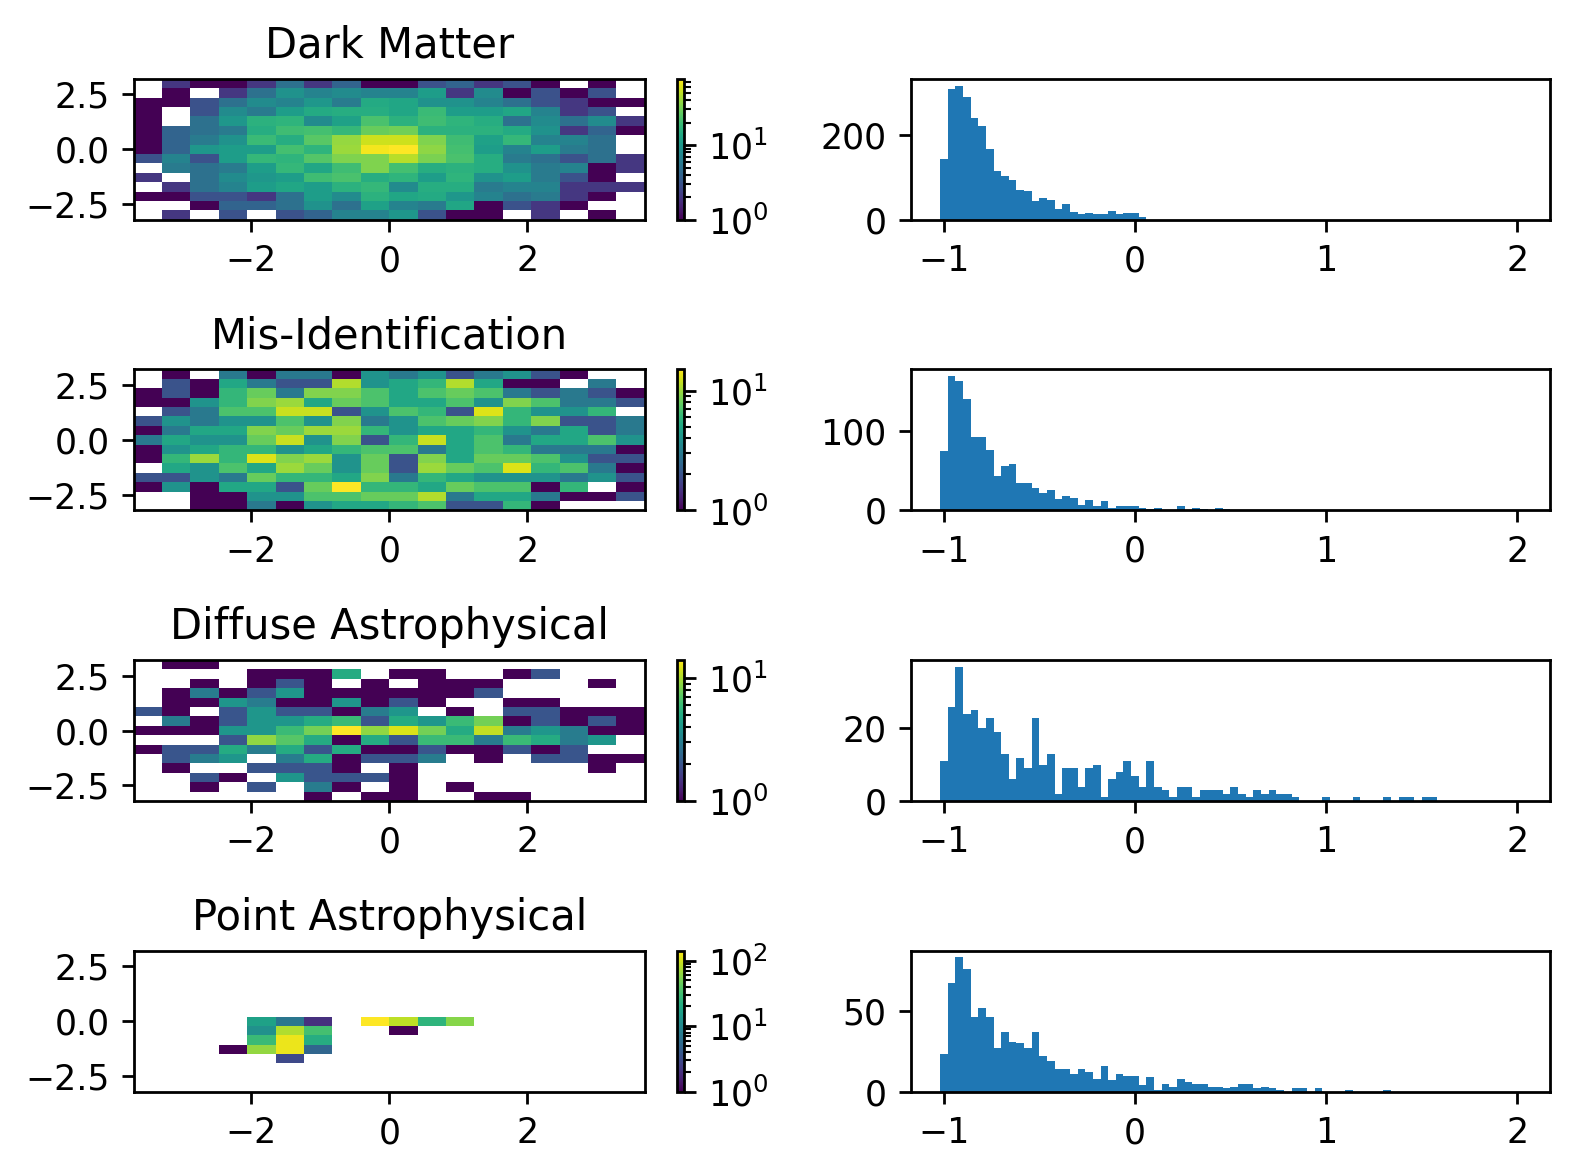

In [21]:
plt.figure(dpi=250)
plt.subplot(421)
plt.title("Dark Matter")
plt.hist2d(signal_lon_measured,signal_lat_measured, bins=(bin_centres_to_edges(longitudeaxis), bin_centres_to_edges(latitudeaxis)), norm=LogNorm())
plt.colorbar()

plt.subplot(422)
plt.hist(signal_log10e_measured, bins=bin_centres_to_edges(log10eaxis[::2]))


plt.subplot(423)
plt.title("Mis-Identification")

plt.hist2d(ccr_lon_measured, ccr_lat_measured, bins=(bin_centres_to_edges(longitudeaxis), bin_centres_to_edges(latitudeaxis)), norm=LogNorm())
plt.colorbar()


plt.subplot(424)
plt.hist(ccr_log10e_measured, bins=bin_centres_to_edges(log10eaxis[::2]))


plt.subplot(425)
plt.title("Diffuse Astrophysical")
plt.hist2d(diffuse_astro_lon_measured,diffuse_astro_lat_measured, bins=(bin_centres_to_edges(longitudeaxis), bin_centres_to_edges(latitudeaxis)), norm=LogNorm())
plt.colorbar()

plt.subplot(426)
plt.hist(diffuse_astro_log10e_measured, bins=bin_centres_to_edges(log10eaxis[::2]))

plt.subplot(427)
plt.title("Point Astrophysical")
plt.hist2d(point_astro_lon_measured,point_astro_lat_measured, bins=(bin_centres_to_edges(longitudeaxis), bin_centres_to_edges(latitudeaxis)), norm=LogNorm())
plt.colorbar()

plt.subplot(428)
plt.hist(point_astro_log10e_measured, bins=bin_centres_to_edges(log10eaxis[::2]))




plt.tight_layout()
plt.show()

## Final simulation output

In [22]:

try:
    measured_log10e = list(signal_log10e_measured)+list(diffuse_astro_log10e_measured)+list(point_astro_log10e_measured)+list(ccr_log10e_measured)
    measured_lon = list(signal_lon_measured)+list(diffuse_astro_lon_measured)+list(point_astro_lon_measured)+list(ccr_lon_measured)
    measured_lat = list(signal_lat_measured)+list(diffuse_astro_lat_measured)+list(point_astro_lat_measured)+list(ccr_lat_measured)
    
except:
    print('what')

# <h1><b>Analysis

## Marginalisation

In [23]:
nbinslogmass=51

if nsig is None:
    nsig = len(list(measured_log10e))

logmasswindowwidth      = 9/np.sqrt(nsig)

logmasslowerbound       = truelogmass-logmasswindowwidth
logmassupperbound       = truelogmass+logmasswindowwidth

# if 1:
if logmasslowerbound<log10eaxis[0]:
    logmasslowerbound = log10eaxis[0]
# if 1:
if logmassupperbound>2:
    logmassupperbound = 2


logmassrange            = np.linspace(logmasslowerbound, logmassupperbound, nbinslogmass) 

In [24]:
hyperparameter_likelihood_instance = hyperparameter_likelihood(priors=(DM_prior, ccr_bkg_prior, diffuse_astro_bkg_prior, point_astro_bkg_prior), likelihood=single_loglikelihood, 
                                                               dependent_axes=(log10eaxistrue,  longitudeaxistrue, latitudeaxistrue), dependent_logjacob=logjacobtrue,
                                                               hyperparameter_axes = ((logmassrange,), (None,), (None,), (None, )), numcores=numcores, likelihoodnormalisation = psfnormalisationvalues+edispnormalisationvalues)

measured_log10e = [float(measured_log10e_val) for measured_log10e_val in measured_log10e]
margresults = hyperparameter_likelihood_instance.nuisance_log_marginalisation(axisvals= (measured_log10e, measured_lon, measured_lat))

Setting up prior matrices: 100%|██████████| 4/4 [02:01<00:00, 30.34s/it] 
Performing parallelized direct event marginalisation: 100%|██████████| 5000/5000 [00:00<00:00, 2019404.91it/s]
/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/gammabayes/likelihoods/instrument_response_funcs_tst.py:120: RuntimeWarning: divide by zero encountered in log
  psf_output = np.log(psffull.evaluate(energy_true=10**psf_value_mesh[2].flatten()*u.TeV,
/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/gammabayes/likelihoods/instrument_response_funcs_tst.py:131: RuntimeWarning: divide by zero encountered in log
  edisp_output =np.log(edispfull.evaluate(energy_true=10**edisp_value_mesh[1].flatten()*u.TeV,


In [25]:
margresultsarray = np.array(margresults)

margresultsarray[0:10].shape

(10, 4)

## Calculating posterior

In [26]:
nbins_sigfrac               = 51
sigfrac_windowwidth         = 10/np.sqrt(Nsamples)
ccrfrac_windowwidth         = 8/np.sqrt(Nsamples)
diffusefrac_windowwidth     = 15/np.sqrt(Nsamples)

nbins_ccr_frac              = 51
nbins_diffuse_frac          = 51

sigfrac_range_upperbound = sigfraction+sigfrac_windowwidth
sigfrac_range_lowerbound = sigfraction-sigfrac_windowwidth



if sigfrac_range_upperbound>1:
    sigfrac_range_upperbound = 1
if sigfrac_range_lowerbound<0:
    sigfrac_range_lowerbound = 0

ccrfrac_of_bkg_range_upperbound = ccr_of_bkg_fraction+ccrfrac_windowwidth
ccrfrac_of_bkg_range_lowerbound = ccr_of_bkg_fraction-ccrfrac_windowwidth

if ccrfrac_of_bkg_range_upperbound>1:
    ccrfrac_of_bkg_range_upperbound = 1
if ccrfrac_of_bkg_range_lowerbound<0:
    ccrfrac_of_bkg_range_lowerbound = 0

diffusefrac_of_astro_range_upperbound = diffuse_of_astro_fraction+diffusefrac_windowwidth
diffusefrac_of_astro_range_lowerbound = diffuse_of_astro_fraction-diffusefrac_windowwidth


if diffusefrac_of_astro_range_upperbound>1:
    diffusefrac_of_astro_range_upperbound = 1
if diffusefrac_of_astro_range_lowerbound<0:
    diffusefrac_of_astro_range_lowerbound = 0


sigfracrange = np.linspace(sigfrac_range_lowerbound,    sigfrac_range_upperbound,   nbins_sigfrac)
ccrfrac_of_bkg_range = np.linspace(ccrfrac_of_bkg_range_lowerbound,ccrfrac_of_bkg_range_upperbound , nbins_ccr_frac)
diffuse_of_astro_range = np.linspace(diffusefrac_of_astro_range_lowerbound,diffusefrac_of_astro_range_upperbound, nbins_diffuse_frac)


skipfactor = 10
mixtureaxes = sigfracrange, ccrfrac_of_bkg_range, diffuse_of_astro_range
new_log_posterior = 0
loopstart = time.perf_counter()
for dataidx in tqdm(range(int(round(margresultsarray.shape[0]/skipfactor)))):
    tempmargresultsarray = margresultsarray[dataidx*skipfactor:dataidx*skipfactor+skipfactor]
    new_log_posterior += hyperparameter_likelihood_instance.create_mixture_log_hyper_likelihood(
        mixture_axes=(*mixtureaxes,), log_margresults=tempmargresultsarray)

    

new_log_posterior = new_log_posterior - special.logsumexp(new_log_posterior)

endertimer = time.perf_counter()


100%|██████████| 500/500 [53:15<00:00,  6.39s/it]


In [27]:
# log_posterior=np.squeeze(new_log_posterior)
log_posterior = np.squeeze(new_log_posterior)
log_posterior.shape
log_posterior[0]

array([[[-300.39992798, -298.65817787, -297.46717864, ...,
         -282.15248051, -282.22230926, -284.28398351],
        [-290.45623804, -288.77967979, -287.61307995, ...,
         -273.82420402, -273.90246819, -275.98846571],
        [-280.83447155, -279.22044343, -278.07721177, ...,
         -265.74028818, -265.82677528, -267.93569697],
        ...,
        [ -86.90196218,  -86.75244832,  -86.15046338, ...,
         -105.22306058, -105.5576786 , -108.10142444],
        [ -87.51038285,  -87.37658854,  -86.78039268, ...,
         -106.16400381, -106.5019834 , -109.0490829 ],
        [ -88.33784682,  -88.21937398,  -87.62882054, ...,
         -107.31476282, -107.65603105, -110.2063506 ]],

       [[-293.32263756, -291.58320709, -290.39603909, ...,
         -274.96186926, -275.02856231, -277.07735266],
        [-283.55510986, -281.88009728, -280.71701548, ...,
         -266.79326648, -266.86827033, -268.94120252],
        [-274.10499835, -272.49179441, -271.35178836, ...,
         -258.

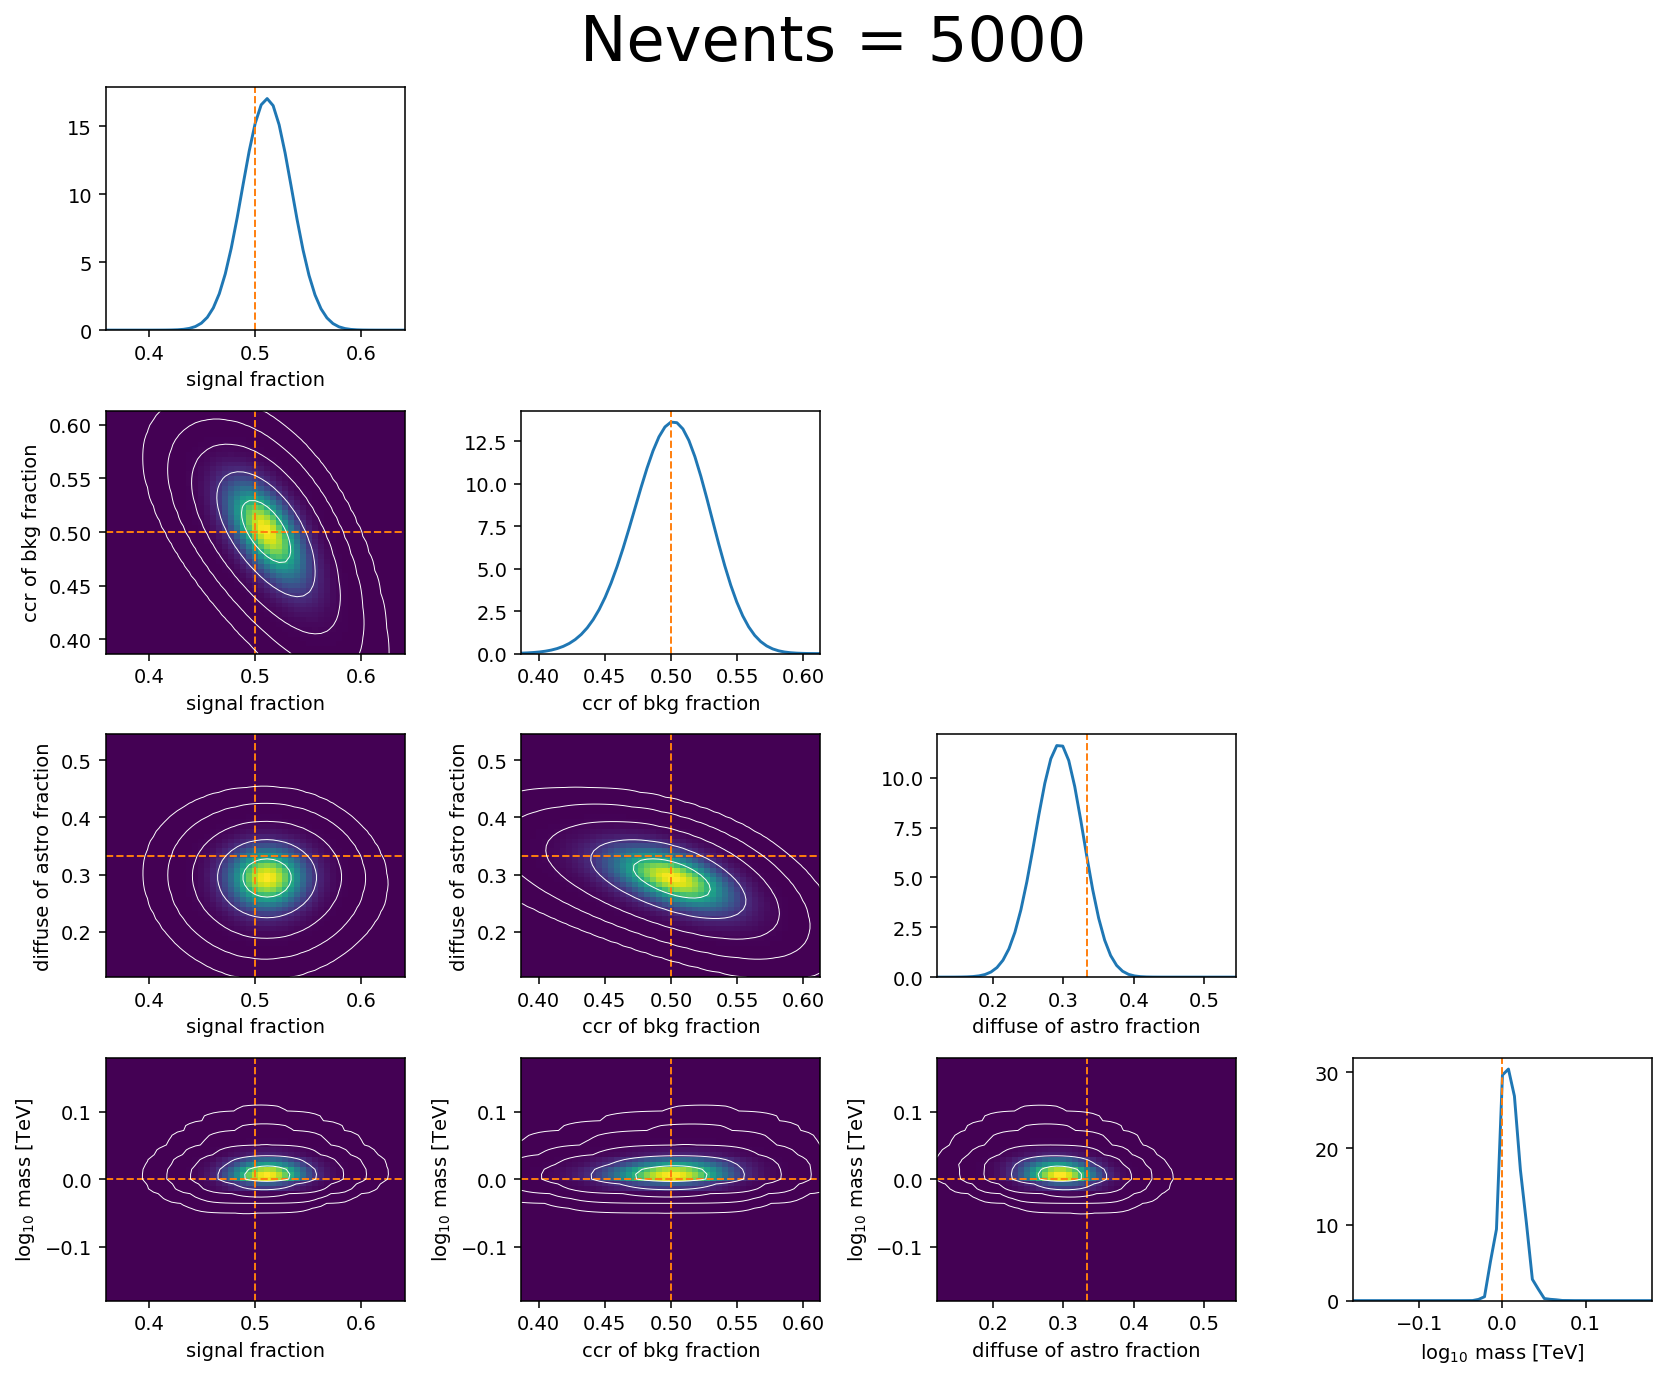

In [35]:
from gammabayes.utils.plotting import logdensity_matrix_plot
from gammabayes.utils.utils import hdp_credible_interval_1d
from scipy.stats import norm as norm1d


logdensity_matrix_plot(axes=(*mixtureaxes, logmassrange,), logprobmatrix=log_posterior-special.logsumexp(log_posterior), 
                       truevals=(sigfraction, ccr_of_bkg_fraction, diffuse_of_astro_fraction, truelogmass,),
                       axis_names=('signal fraction', 'ccr of bkg fraction', 'diffuse of astro fraction', r'log$_{10}$ mass [TeV]', ),
                       sigmalines_1d=False,
                       dpi=140, figsize=(12,10))
plt.suptitle(f'Nevents = {Nsamples}', size=32)
plt.tight_layout()
plt.show()


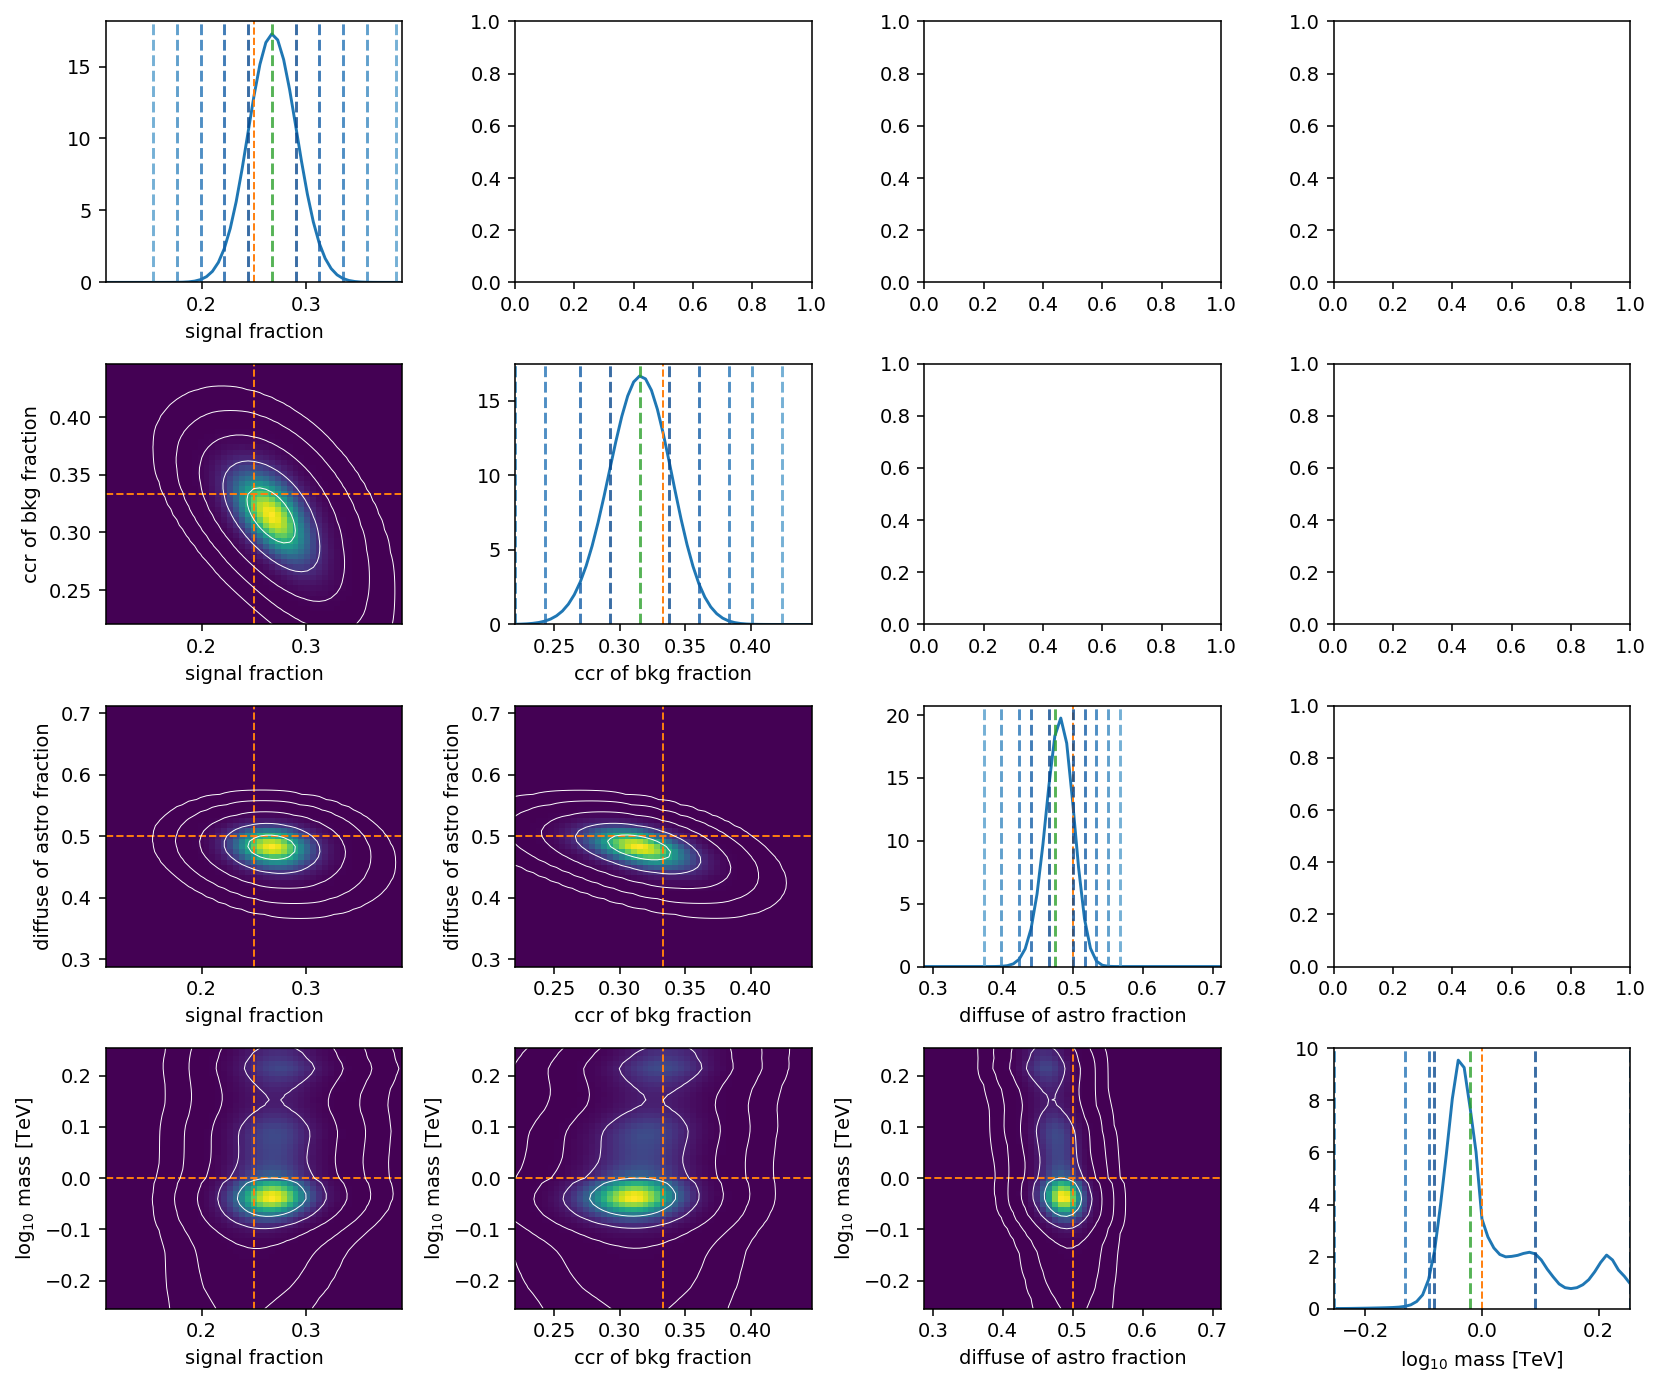

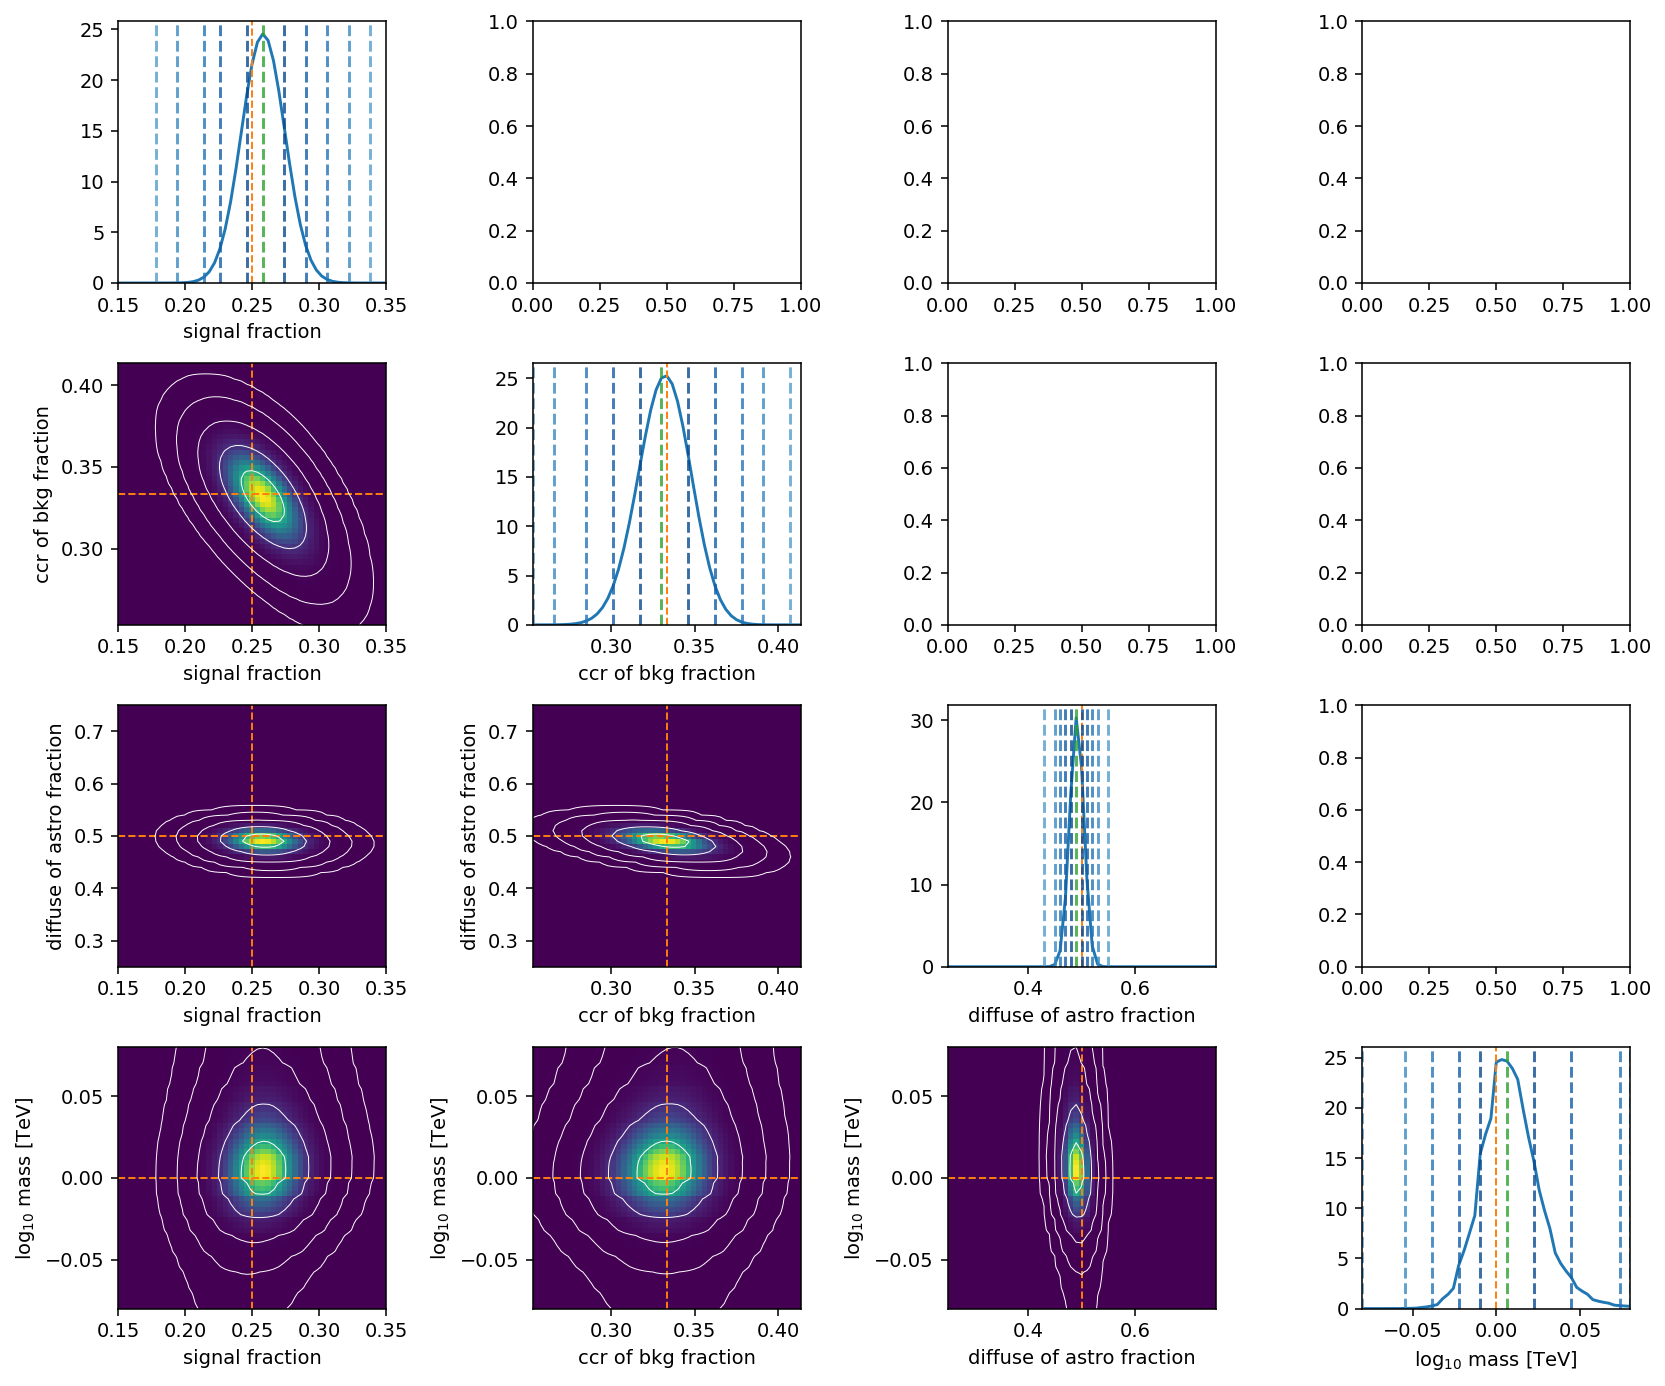

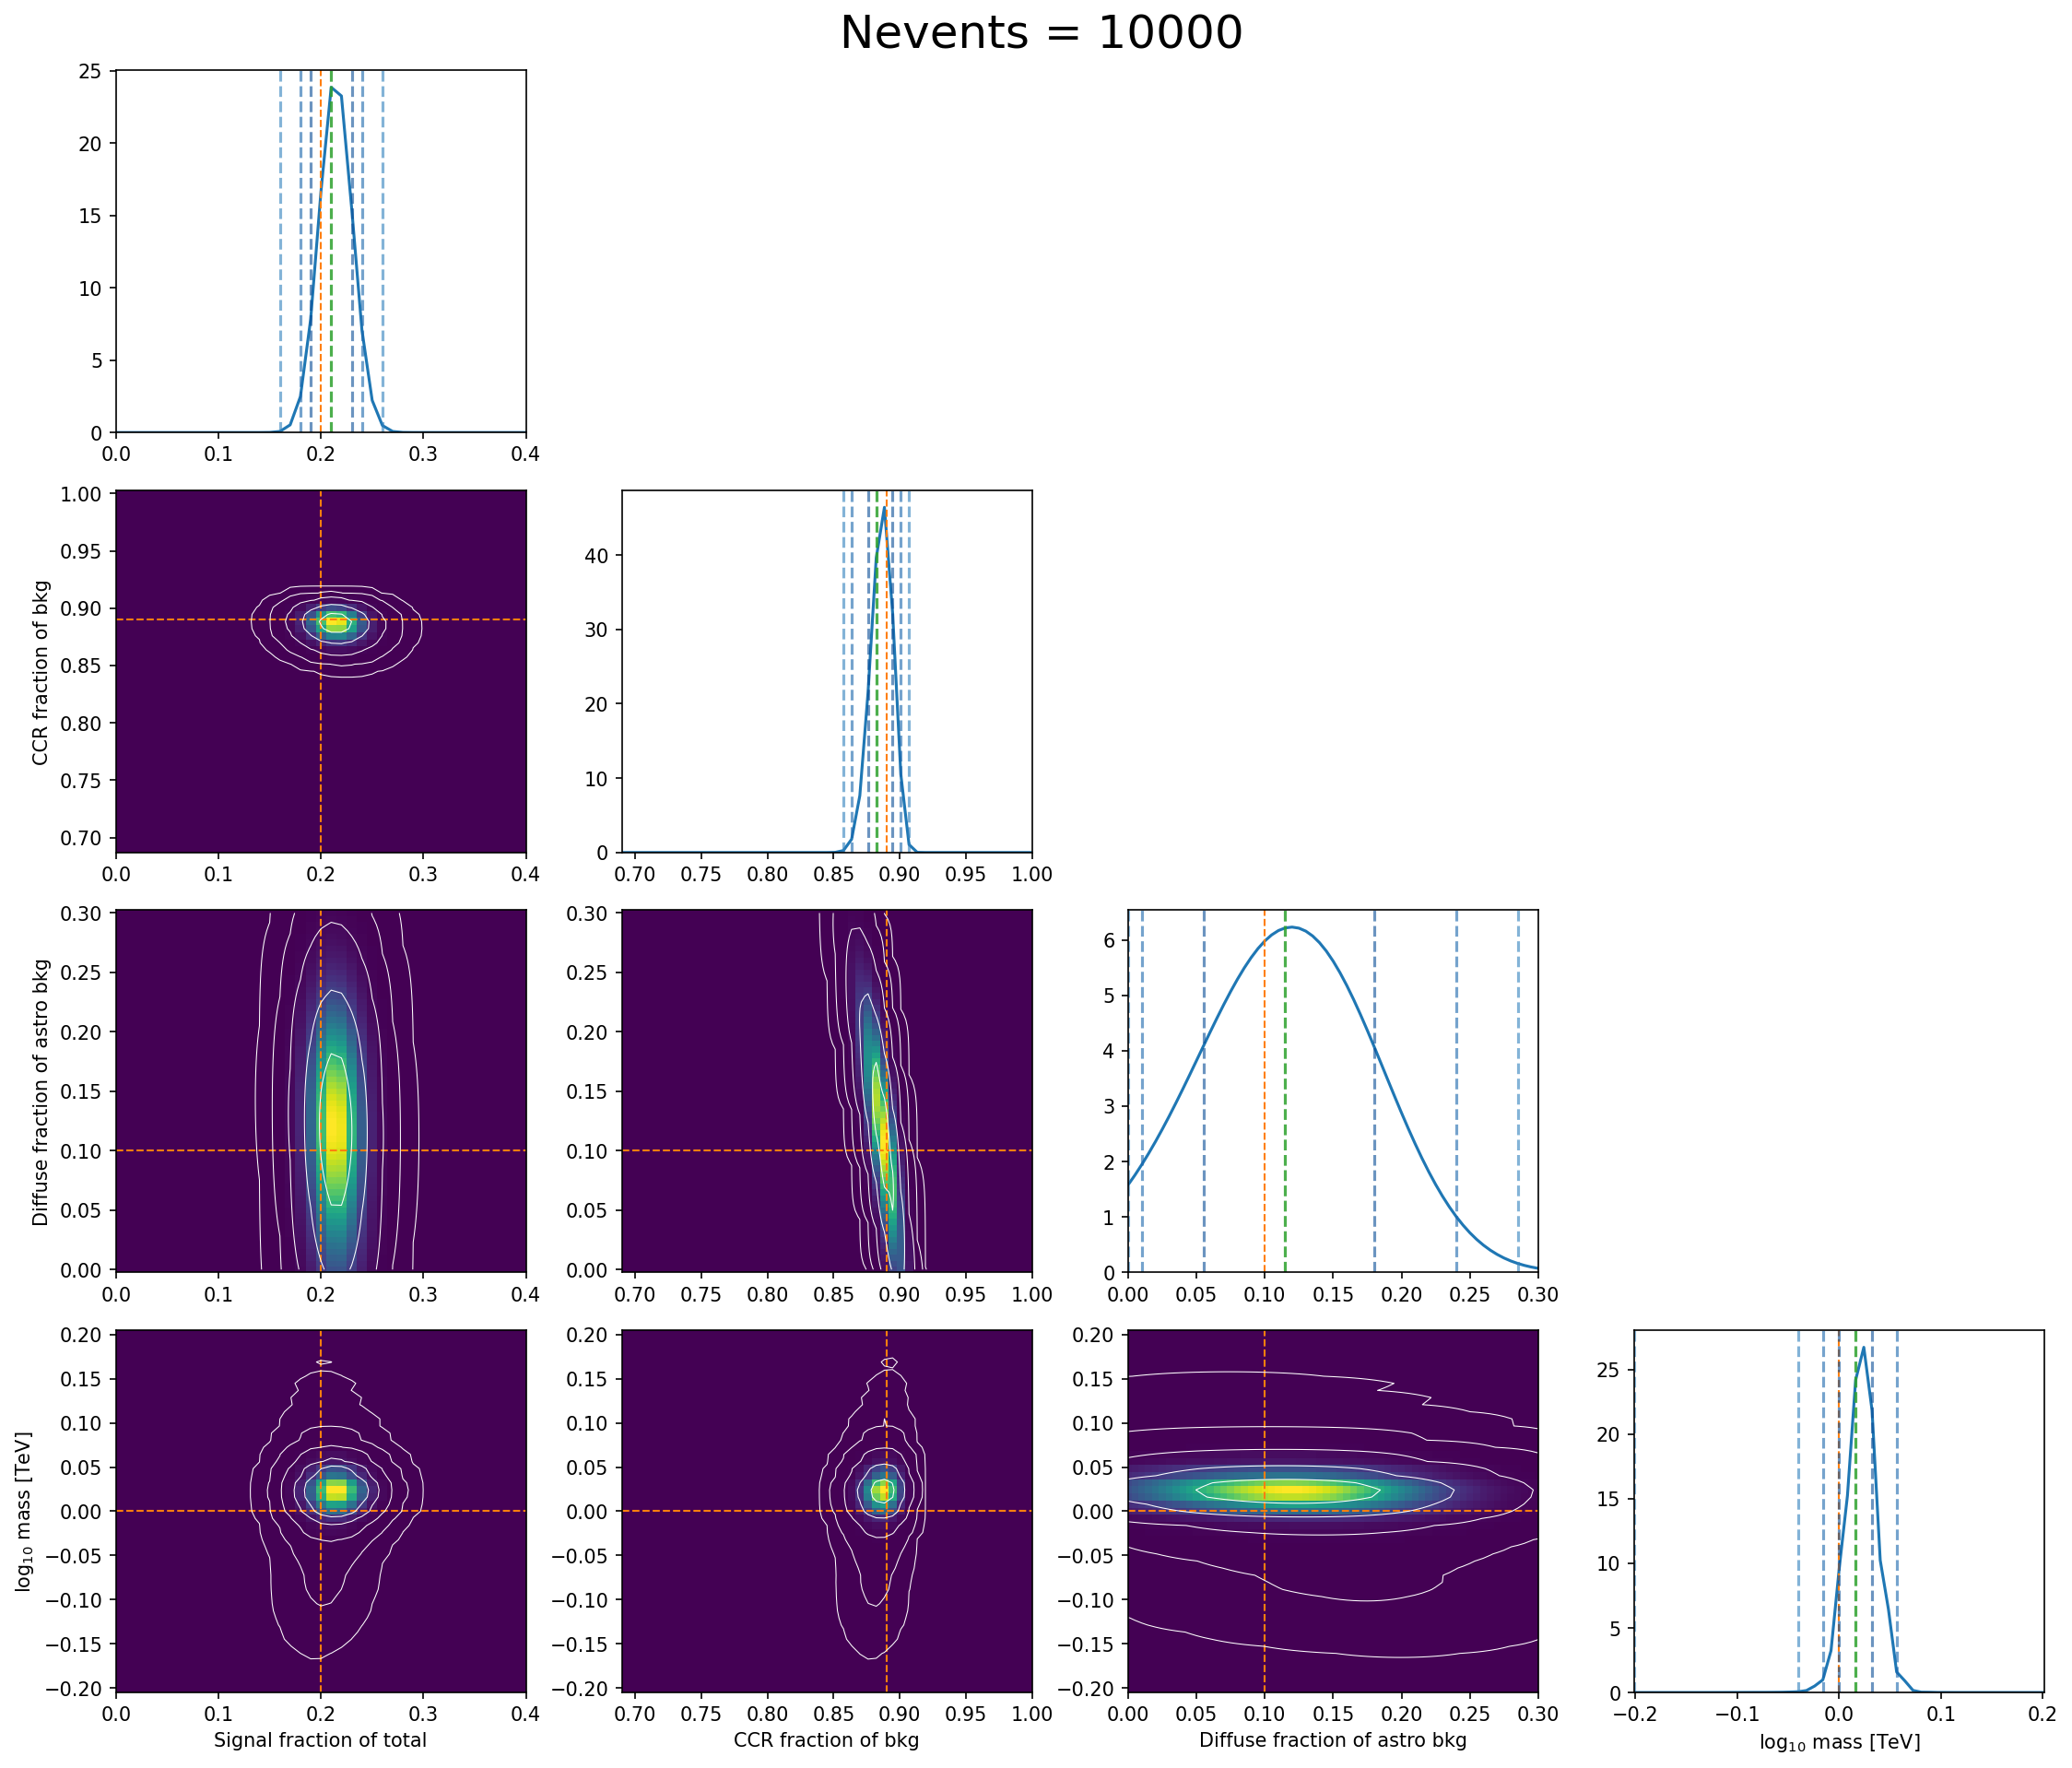

In [29]:
os.system("say beep")

0